<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1번

데이터 설명 : 집과 관련된 여러 수치들과 집의 가격, log1p 정규화된 price 컬럼 예측 하기 </br>
데이터 출처 : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv 일부 전처리
data Url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/p3/problem1.csv

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [274]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/17/problem1.csv')
df.head()

,Id,LotArea,LotFrontage,YearBuilt,1stFlrSF,2ndFlrSF,YearRemodAdd,TotRmsAbvGrd,KitchenAbvGr,BedroomAbvGr,GarageCars,GarageArea,price
0,1,8450,65.0,2003,856,854,2003,8,1,3,2,548,12.247699
1,2,9600,80.0,1976,1262,0,1976,6,1,3,2,460,12.109016
2,3,11250,68.0,2001,920,866,2002,6,1,3,2,608,12.317171
3,4,9550,60.0,1915,961,756,1970,7,1,3,3,642,11.849405
4,5,14260,84.0,2000,1145,1053,2000,9,1,4,3,836,12.429220


1.1 데이터 EDA 수행 후, 분석가 입장에서 의미있는 탐색

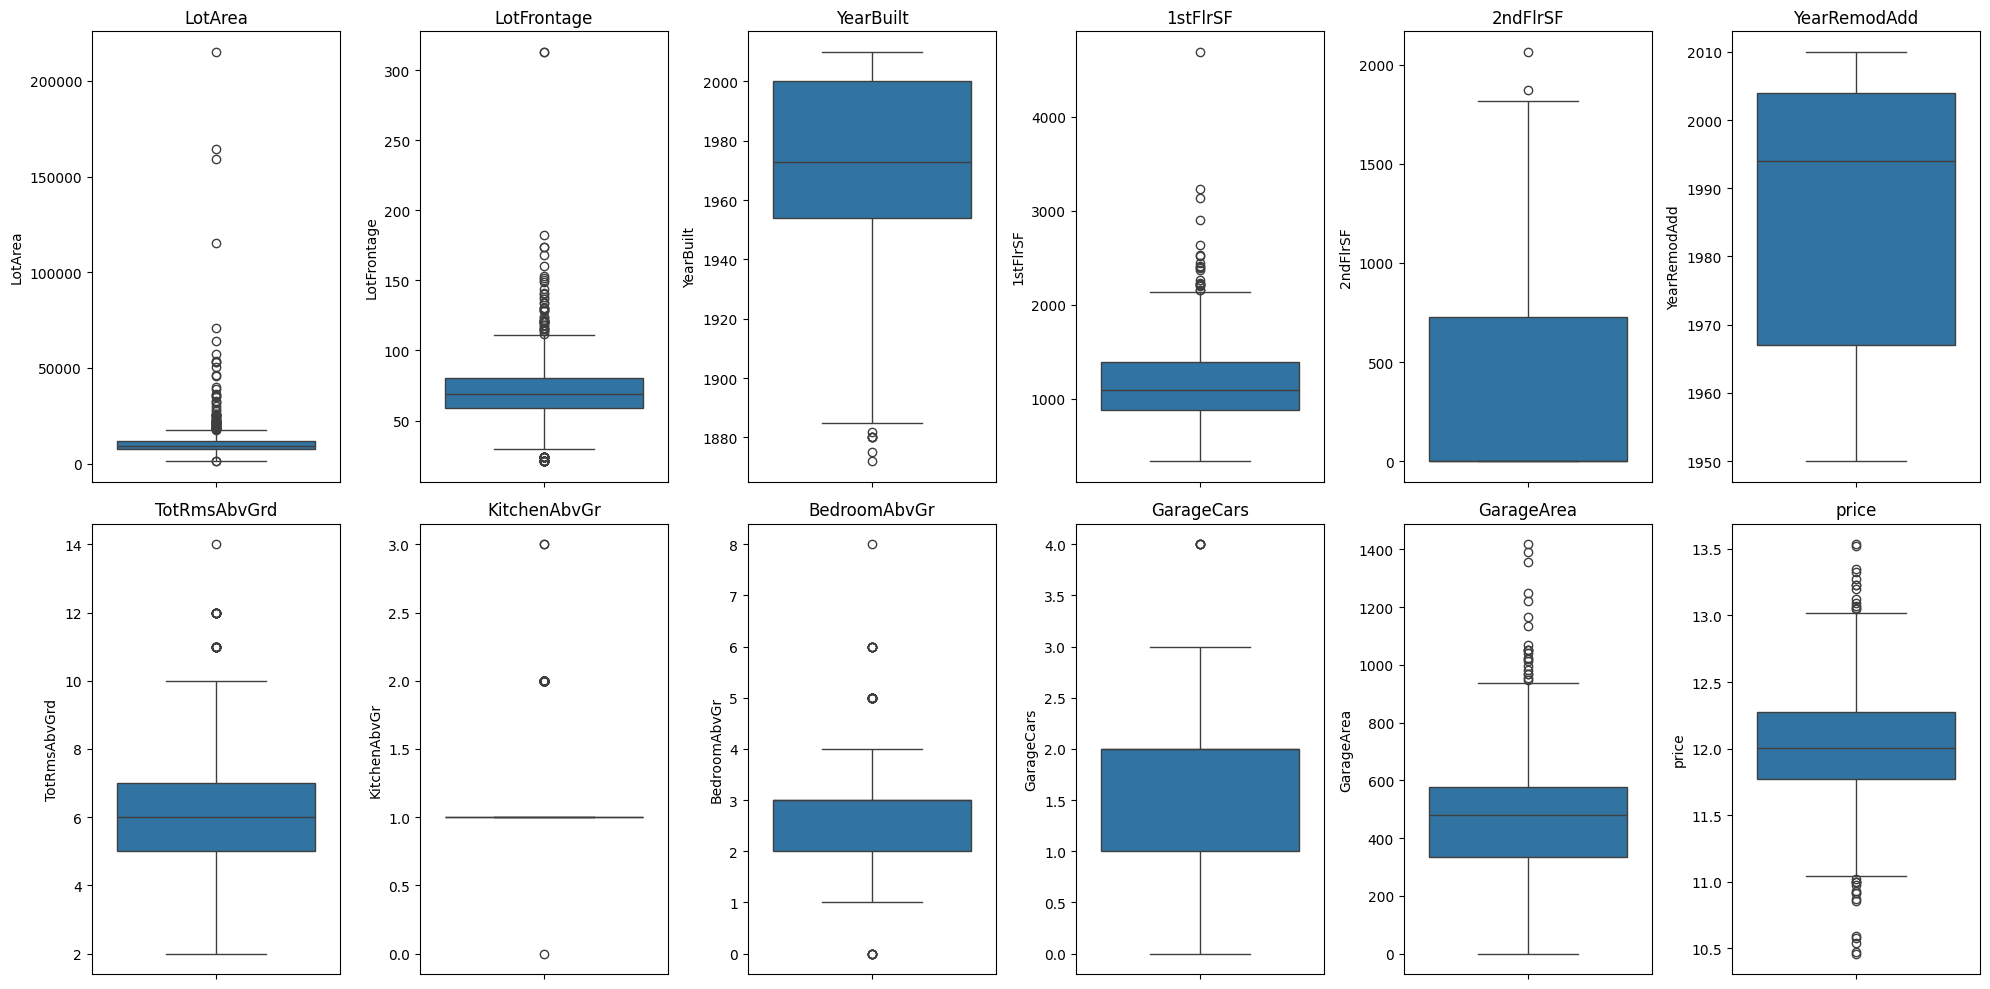

,LotArea,LotFrontage,YearBuilt,1stFlrSF,2ndFlrSF,YearRemodAdd,TotRmsAbvGrd,KitchenAbvGr,BedroomAbvGr,GarageCars,GarageArea,price
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,70.049958,1971.267808,1162.626712,346.992466,1984.865753,6.517808,1.046575,2.866438,1.767123,472.980137,12.024057
std,9981.264932,24.284752,30.202904,386.587738,436.528436,20.645407,1.625393,0.220338,0.815778,0.747315,213.804841,0.399449
min,1300.000000,21.000000,1872.000000,334.000000,0.000000,1950.000000,2.000000,0.000000,0.000000,0.000000,0.000000,10.460271
25%,7553.500000,59.000000,1954.000000,882.000000,0.000000,1967.000000,5.000000,1.000000,2.000000,1.000000,334.500000,11.775105
50%,9478.500000,69.000000,1973.000000,1087.000000,0.000000,1994.000000,6.000000,1.000000,3.000000,2.000000,480.000000,12.001512
75%,11601.500000,80.000000,2000.000000,1391.250000,728.000000,2004.000000,7.000000,1.000000,3.000000,2.000000,576.000000,12.273736
max,215245.000000,313.000000,2010.000000,4692.000000,2065.000000,2010.000000,14.000000,3.000000,8.000000,4.000000,1418.000000,13.534474



데이터의 분포도를 시각화를 통해 분석한 결과
LotArea, LotFrontage, 2dnFlrSF 등의 분포가 한 쪽으로 쏠려있는 것으로 보아 이상치가 있을 수 있어, 이상치 확인을 할 필요가 있어보인다. 
1stFlrSF	2ndFlrSF의 경우 max 값과 75%의 값의 차이가 확실히 보여지는 것으로 보아 이상치를 처리해야하는 것으로 보인다. 
이상치 제거 또는 차후 로그 변환을 통해 데이터의 정규성을 확보해야할 것으로 보인다.




In [275]:
# 1) 분포 시각화
df2 = df.drop(columns = ['Id'],axis = 1)

cols = df2.columns.tolist()

fig, axes = plt.subplots(2,6, figsize = (20, 10))

for i, axes in enumerate(axes.flat[:len(cols)]):
  col_i = cols[i]
  sns.boxplot(df2[col_i], ax = axes)
  axes.set_title(col_i)


plt.tight_layout()
plt.show()

display(df2.describe())
print("""
데이터의 분포도를 시각화를 통해 분석한 결과
LotArea, LotFrontage, 2dnFlrSF 등의 분포가 한 쪽으로 쏠려있는 것으로 보아 이상치가 있을 수 있어, 이상치 확인을 할 필요가 있어보인다.
1stFlrSF	2ndFlrSF의 경우 max 값과 75%의 값의 차이가 확실히 보여지는 것으로 보아 이상치를 처리해야하는 것으로 보인다.
이상치 제거 또는 차후 로그 변환을 통해 데이터의 정규성을 확보해야할 것으로 보인다.

""")

In [276]:
# 2) 결측치 확인
display(df2.isnull().sum() / len(df2))
print("""
결측치를 처리하는 방법은 결측치의 비율에 따라 다음에 따라 처리한다.
- 10% 미만 : 삭제하거나 다른 값으로 치완, 평균, 중앖값, 최빈값 / KNN 회귀 모델 등을 통해 결측치 보간
- 10 ~ 50% : 중간 수준 결측치로, 평균, 중앙값, 최빈값으로 대체 / 다중 대체법, 회귀 대체법 사용
- 50 % 이상 : 변수 삭제

LotFrontage의 결측은 10%가 조금 넘음으로 평균으로 결측치를 대체하도록한다.
""")

# 평균으로 결측 대체한 데이터를 df3으로 지정
df2['LotFrontage'] = df2['LotFrontage'].fillna(df2['LotFrontage'].mean())
df3 = df2.copy()

,0
LotArea,0.000000
LotFrontage,0.177397
YearBuilt,0.000000
1stFlrSF,0.000000
2ndFlrSF,0.000000
YearRemodAdd,0.000000
TotRmsAbvGrd,0.000000
KitchenAbvGr,0.000000
BedroomAbvGr,0.000000
GarageCars,0.000000



결측치를 처리하는 방법은 결측치의 비율에 따라 다음에 따라 처리한다.
- 10% 미만 : 삭제하거나 다른 값으로 치완, 평균, 중앖값, 최빈값 / KNN 회귀 모델 등을 통해 결측치 보간
- 10 ~ 50% : 중간 수준 결측치로, 평균, 중앙값, 최빈값으로 대체 / 다중 대체법, 회귀 대체법 사용
- 50 % 이상 : 변수 삭제 

LotFrontage의 결측은 10%가 조금 넘음으로 평균으로 결측치를 대체하도록한다.



Train,Valid,Test set으로 분할 및 시각화 제시

In [277]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1) Scaling 을 통한 단위변환
s_df = df3.copy()
s_X = df2.drop(columns =['price'], axis = 1)
s_y = df2['price']

ss_X = pd.DataFrame(StandardScaler().fit_transform(s_X), columns = s_X.columns)

X_train, X_test, y_train, y_test= train_test_split(ss_X, s_y, test_size = 0.2, random_state = 42)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(r2_score(y_test, lr_pred))
print(np.sqrt(mean_squared_error(y_test, lr_pred)))

0.8095151461262806
0.18853797201787215


In [278]:
# 2) Scaling 하지 않았을때
s_df = df3.copy()
s_X = df2.drop(columns =['price'], axis = 1)
s_y = df2['price']

X_train, X_test, y_train, y_test= train_test_split(s_X, s_y, test_size = 0.2, random_state = 42)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print(r2_score(y_test, lr_pred))
print(np.sqrt(mean_squared_error(y_test, lr_pred)))

0.8095151461262816
0.1885379720178716


In [279]:
# 3) 교차 검증에 대한 결과
# 목적) 모델이 훈련 데이터만 적합(FIT)되고 테스트 데이터에서는 성능이 떨어지는 과적합 문제를 해결하기 위해서이다.
# 교차 검증을 사용하여 분할이 여러번 반복되어짐으로, 샘플링 편향을 방지 할 수 있다.

cv = cross_val_score(lr ,ss_X, s_y, cv = 10, scoring= 'r2')
np.mean(cv)

0.7714860260216791

1-4. 모형에 적합한 기계학습 모델 3가지 구현

In [280]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

s_df = df3.copy()
s_X = df2.drop(columns =['price'], axis = 1)
s_y = df2['price']

ss_X = pd.DataFrame(StandardScaler().fit_transform(s_X), columns = s_X.columns)

X_train, X_test, y_train, y_test= train_test_split(ss_X, s_y, test_size = 0.2, random_state = 42)


models = {
    'rf' : RandomForestRegressor(random_state = 42) ,
    'ridge' : Ridge(),
    'svr' : SVR()

}
# 2) K-Fold
kfold = KFold(n_splits = 5, shuffle= True, random_state = 42)


result = []
for name, model in models.items():
  # cross_val_score
  cv = cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'r2')
  mean_acuuracy = cv.mean()

  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  r2 = r2_score(y_test, pred)
  MSE = np.sqrt(mean_squared_error(y_test, pred))
  result.append([name, r2, MSE, mean_acuuracy])

pd.DataFrame(result, columns = ['Modle', 'r2_score', 'MSE','mean_acuuracy'])

,Modle,r2_score,MSE,mean_acuuracy
0,rf,0.821134,0.182697,0.796941
1,ridge,0.809405,0.188592,0.765419
2,svr,0.844027,0.170606,0.810403


2번
데이터 설명 : 코로나19에 대한 나라별 데이터로 모델링 진행 </br>
데이터 출처 : https://www.kaggle.com/imdevskp/corona-virus-report 일부 후처리 </br>
data Url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/p3/problem2.csv

In [281]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/17/problem2.csv')
df = df.fillna(0)

# 신규 확진자,
for location in df.location.unique():
    lo = df[df.location == location]
    df.loc[lo.index,'new_cases'] =lo.total_cases.diff().values
    df.loc[lo.index[0], 'new_cases'] = lo['total_cases'].values[0]

    df.loc[lo.index,'new_deaths'] =lo.total_deaths.diff().values
    df.loc[lo.index[0], 'new_deaths'] = lo['total_deaths'].values[0]

    df.loc[lo.index, 'total_vacciantions'] = lo['new_vaccinations'].cumsum().values
    df.loc[lo.index, '7days_new_case'] = lo['new_tests'].rolling(7).sum().fillna(0).values

df.head()


,location,date,total_cases,total_deaths,new_tests,population,new_vaccinations,new_cases,new_deaths,total_vacciantions,7days_new_case
0,Afghanistan,2020-02-24,5.0,0.0,0.0,39835428.0,0.0,5.0,0.0,0.0,0.0
1,Afghanistan,2020-02-25,5.0,0.0,0.0,39835428.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,2020-02-26,5.0,0.0,0.0,39835428.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,2020-02-27,5.0,0.0,0.0,39835428.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,2020-02-28,5.0,0.0,0.0,39835428.0,0.0,0.0,0.0,0.0,0.0


마지막 일자를 기준으로 인구 대비 확진자 비율이 높은 상위 5개 국가를 구하여라
상위 5개 국가별로 누적 확진자, 일일 확진자, 누적 사망자, 일일 사망자, 그래프, 범례를 이용해서 가독성 있게 만들어라

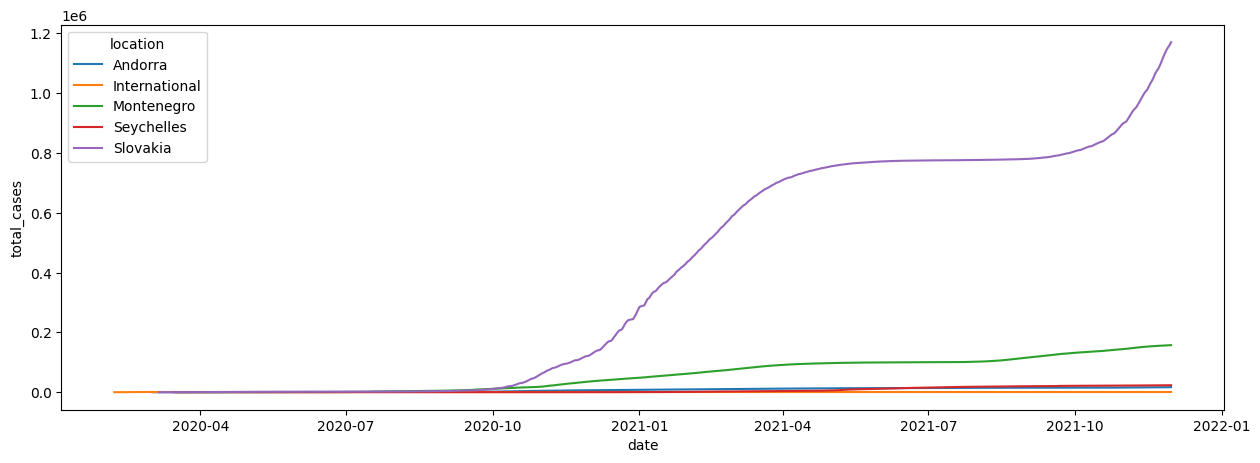

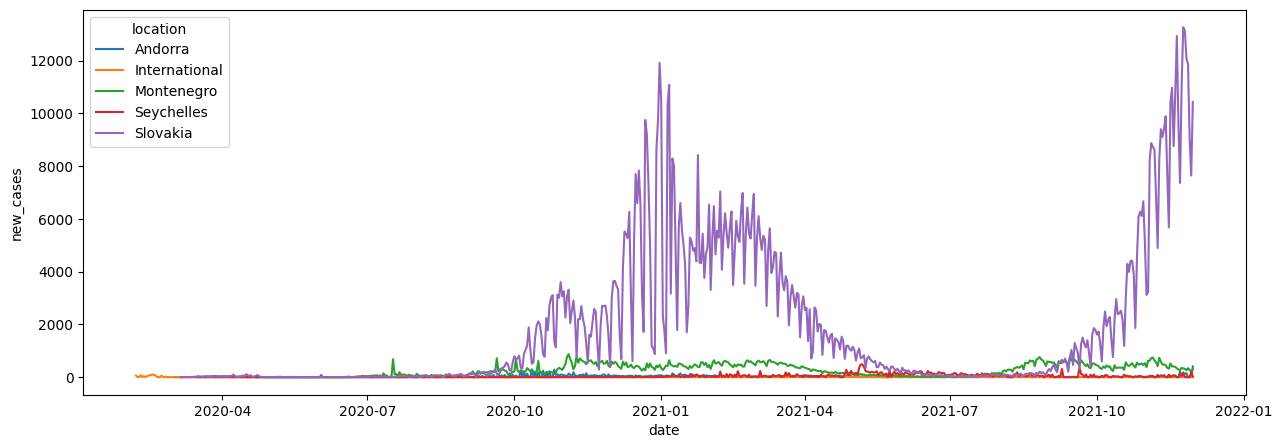

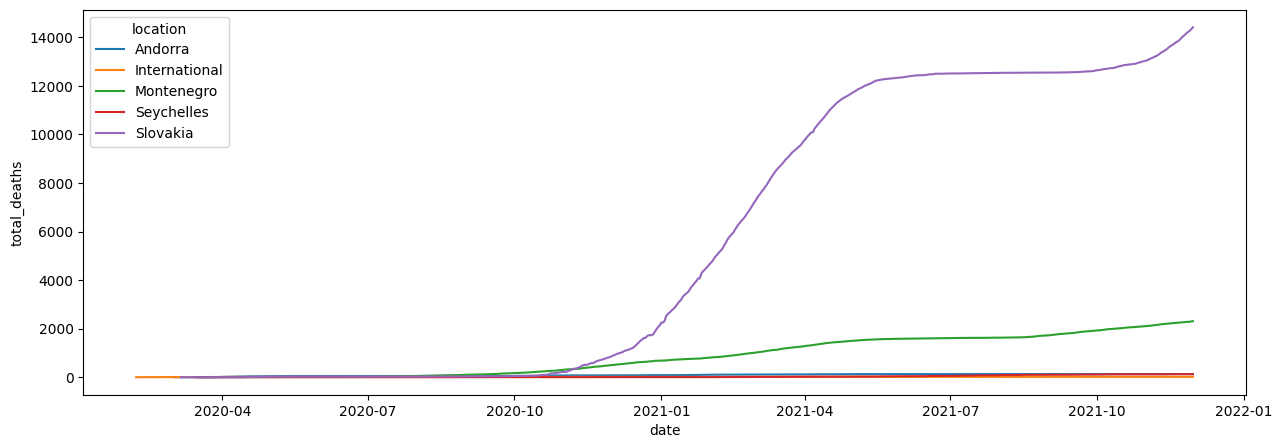

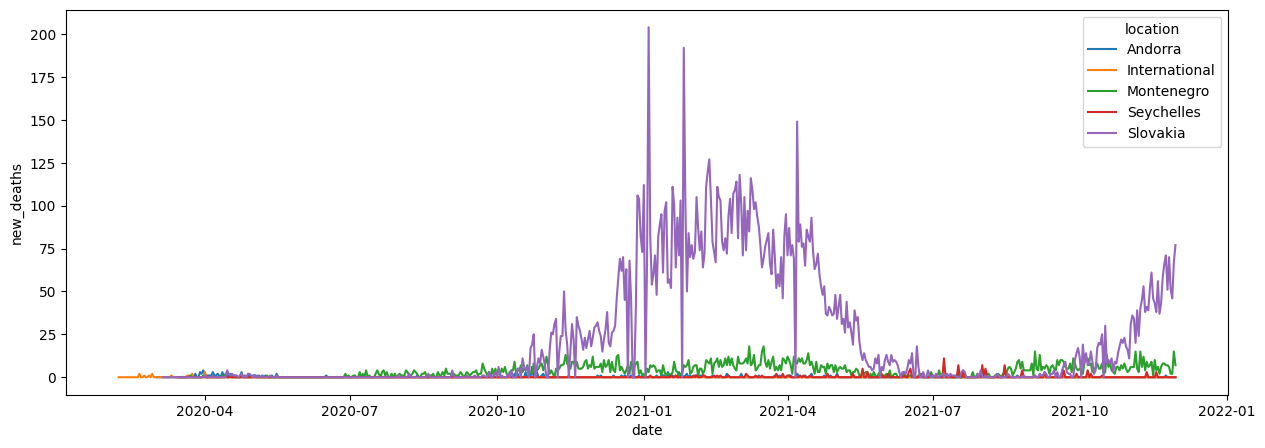

In [282]:

# 확진자 비율 구하기
df['ratio'] = df['total_cases'] / df['population']

df['date'] = pd.to_datetime(df['date'])
max_date = df['date'].max()

last_df = df.loc[df['date'] == max_date].reset_index(drop = True)
top5_countries = last_df.groupby(['location']).agg({'ratio':'max'}).sort_values('ratio', ascending = False).head(5)
# 나라 추출
top5 = list(top5_countries.index)


top5_df = df[df['location'].isin(top5)].reset_index(drop = True)
top5_df

# 누적 확진자, 일일 확진자, 누적 사망자, 일일 사망자,

for v in  ["total_cases", "new_cases", "total_deaths", "new_deaths"]:
  plt.figure(figsize = (15,5))
  sns.lineplot(data = top5_df, x = top5_df['date'],y = top5_df[v], hue = top5_df['location'])

코로나 위험지수를 직접 만들고 그 위험지수에 대한 설명을 적고 위험지수가 높은 국가들 10개를 선정해서 시각화

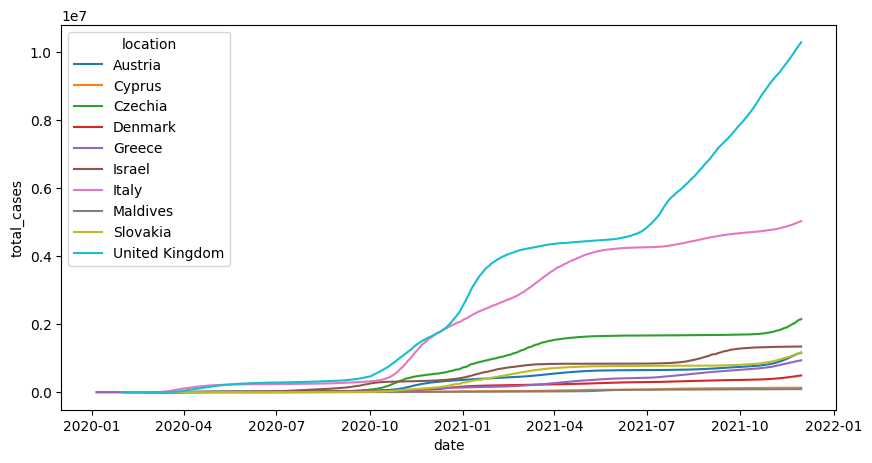

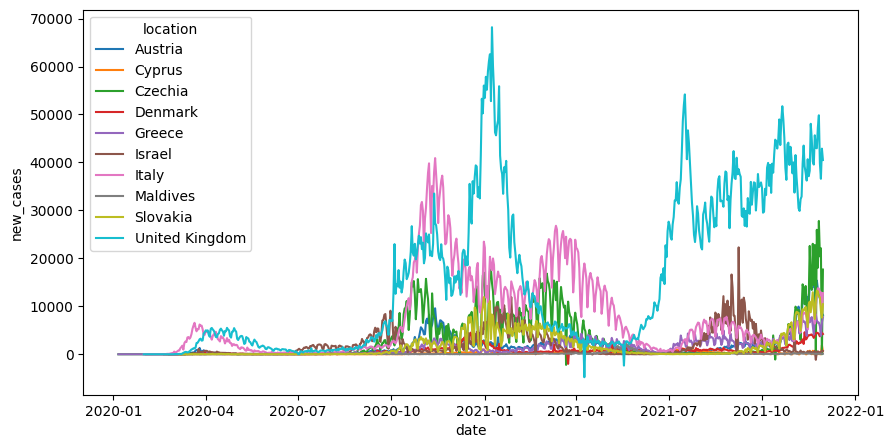

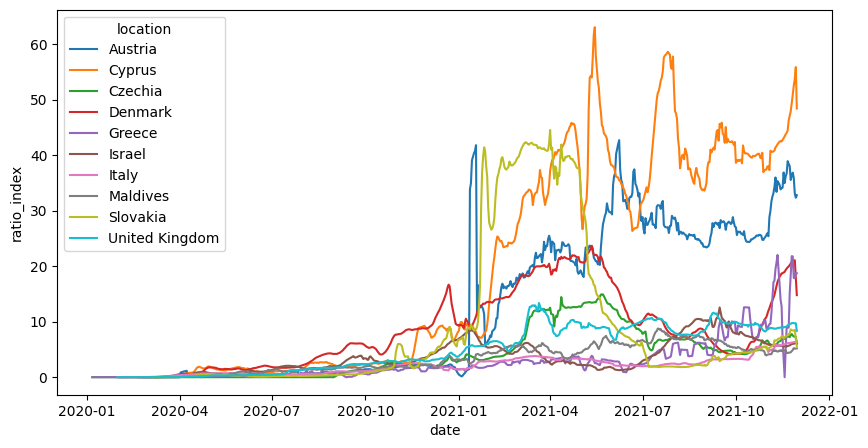

In [283]:
# 위험 지수 ( 최근일주일 누적 확진자 / 인구수)   + (일일 사망자 / 인구수) - (누적 백신 인구 / 인구수) * 보정 상수) * 보정 상수

df['ratio_index'] = (df['7days_new_case'] / df['population'] + df['new_deaths'] / df['population'] - df['total_cases'] / df['population'] *0.001) * 100

# tail를 쓰면 group by 의 1번째 것들만 추출되서 나옴
index_top_10 = df.groupby(['location']).tail(1).sort_values('ratio_index', ascending = False).location.head(10).values


target = df[df['location'].isin(index_top_10)].reset_index(drop = True)
target

for v in ['total_cases','new_cases','ratio_index'] :
  plt.figure(figsize = (10,5))
  sns.lineplot(data = target, x = 'date', y = target[v], hue = 'location')
  plt.show()

한국의 코로나 신규 확진자 예측해라(선형 시계열모델 + 비선형시계열 각각 한개씩 만들어라)

                            AutoReg Model Results                             
Dep. Variable:              new_cases   No. Observations:                  680
Model:                     AutoReg(7)   Log Likelihood               -4335.471
Method:               Conditional MLE   S.D. of innovations            151.877
Date:                Sun, 02 Mar 2025   AIC                           8688.943
Time:                        10:36:18   BIC                           8729.549
Sample:                             7   HQIC                          8704.668
                                  680                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -8.1530      7.799     -1.045      0.296     -23.439       7.133
new_cases.L1     0.7672      0.042     18.422      0.000       0.686       0.849
new_cases.L2    -0.2744      0.053     -5.16

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  680
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -4441.324
Date:                Sun, 02 Mar 2025   AIC                           8894.647
Time:                        10:36:19   BIC                           8921.771
Sample:                             0   HQIC                          8905.147
                                - 680                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5061      0.050    -10.153      0.000      -0.604      -0.408
ar.L2          0.1047      0.057      1.838      0.066      -0.007       0.216
ar.L3         -0.3273      0.035     -9.352      0.0

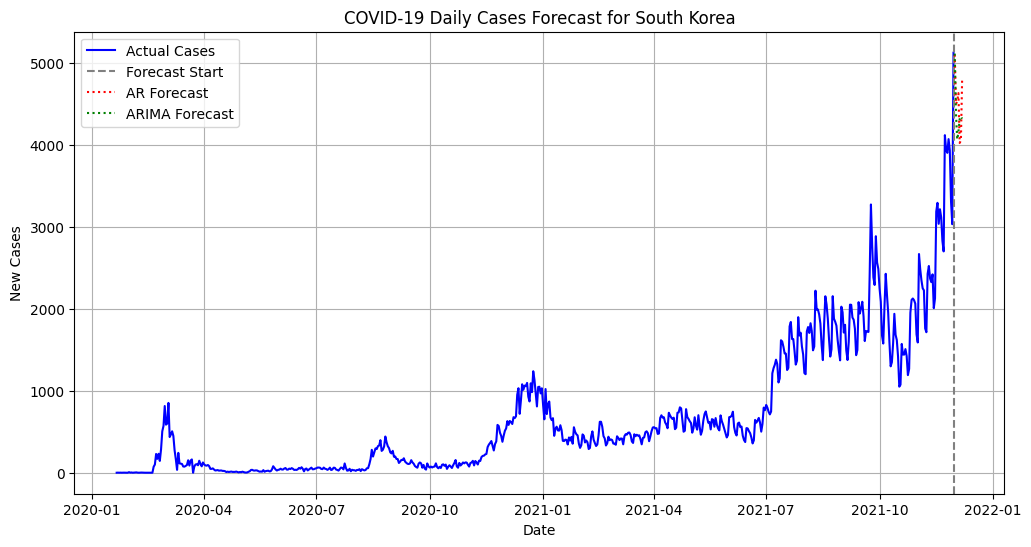

In [284]:
korea = df.loc[df['location']== 'South Korea'].reset_index(drop = True)

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

ar_model = AutoReg(korea["new_cases"], lags=7)  # 최근 7일 데이터를 사용하여 예측
ar_res = ar_model.fit()
print(ar_res.summary())

# ✅ 3. AutoReg 예측 (7일)
ar_forecast = ar_res.predict(start=len(korea), end=len(korea) + 6)

# ✅ 4. 비선형 모델 - ARIMA
arima_model = ARIMA(korea["new_cases"], order=(3,1,2))  # 최적 order 튜닝 (p,d,q)
arima_res = arima_model.fit()
print(arima_res.summary())

# ✅ 5. ARIMA 예측 (7일)
arima_forecast = arima_res.forecast(steps=7)

# ✅ 6. 예측 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(korea["date"], korea["new_cases"], label="Actual Cases", color="blue")
plt.axvline(korea["date"].iloc[-1], color='gray', linestyle="--", label="Forecast Start")
plt.plot(pd.date_range(start=korea["date"].iloc[-1], periods=8, freq="D")[1:], ar_forecast, label="AR Forecast", linestyle="dotted", color="red")
plt.plot(pd.date_range(start=korea["date"].iloc[-1], periods=8, freq="D")[1:], arima_forecast, label="ARIMA Forecast", linestyle="dotted", color="green")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.title("COVID-19 Daily Cases Forecast for South Korea")
plt.legend()
plt.grid()
plt.show()

역문항을 변환 한 후 각 그룹(A~D)의 영역(Q1~Q5)별 응답의 평균, 표준편차, 왜도, 첨도를 구하라. (각 통계량 별로 4x5 dataframe 생성)

In [338]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/17/problem3.csv')
df.head()


,userid,group,Q1-1,Q1-2,Q1-3,Q1-4,Q2-1,Q2-2,Q2-3,Q2-4,...,Q3-3,Q3-4,Q4-1,Q4-2,Q4-3,Q4-4,Q5-1,Q5-2,Q5-3,Q5-4
0,0,A,5,2,1,2,4,5,3,3,...,1,1,5,2,5,3,3,4,3,4
1,1,A,2,2,3,3,4,3,1,4,...,2,3,4,3,5,3,1,2,1,1
2,2,A,1,3,4,4,2,1,4,4,...,4,2,1,3,4,1,3,3,2,5
3,3,A,3,3,4,2,2,4,4,3,...,2,3,3,4,2,4,1,1,3,2
4,4,A,3,1,2,3,4,3,4,1,...,5,1,3,2,3,1,3,2,5,4


In [339]:
# 1-1 문제가 “나는 시간약속을 잘 지킨다.”라는 문제라면 1-3의 문제는 “나는 시간약속을 잘 지키지 않는다.” 라는 역문제로 구성 되어있다.
#각 영역의 3번문항의 1번문항의 역문제이다. 모든 답변은 5점 척도이다. 문제를 풀기전 모든 역문항의 경우 점수를 변환(6점을 빼서) 작업이 필요

# 각 Question의 3번은 6를 뺀다.
for num in range(1, 6) :
  df[f'Q{num}-3'] = 6 - df[f'Q{num}-3']

In [340]:
# ✅ Pandas 기반 코드로 변환하여 동일한 결과를 내도록 조정

result_dict = {}  # 최종 결과 저장

for num in range(1, 6):
    col_lst = ['group'] + [f'Q{num}-{col}' for col in range(1, 5)]


    target = df[col_lst]

    #
    melted_df = target.melt(id_vars=['group'], var_name='Question', value_name=f'Q{num}')

    # 그룹별 통계량 계산 (mean, std, skew, kurtosis)
    stats_df = melted_df.groupby('group')[f'Q{num}'].agg(['mean', 'std', skew, kurtosis])

    #  결과 저장
    result_dict[f'Q{num}'] = stats_df

#  최종 결과 출력
for key, value in result_dict.items():
    print(f"📌 {key} 그룹별 통계량")
    display(value)


📌 Q1 그룹별 통계량


,mean,std,skew,kurtosis
group,,,,
A,3.016,1.263860,-0.077687,-1.088449
B,3.042,1.242489,-0.126561,-1.023791
C,3.030,1.243642,-0.050550,-1.034081
D,2.991,1.264325,-0.069317,-1.082000


📌 Q2 그룹별 통계량


,mean,std,skew,kurtosis
group,,,,
A,3.058,1.236999,-0.129196,-0.998148
B,3.048,1.266215,-0.110876,-1.061531
C,3.063,1.256427,-0.121846,-1.047372
D,3.091,1.249913,-0.166085,-1.019060


📌 Q3 그룹별 통계량


,mean,std,skew,kurtosis
group,,,,
A,2.992,1.268679,-0.061507,-1.098840
B,3.050,1.238965,-0.116982,-1.036495
C,3.023,1.248210,-0.102176,-0.989635
D,3.034,1.255556,-0.127851,-1.043880


📌 Q4 그룹별 통계량


,mean,std,skew,kurtosis
group,,,,
A,3.043,1.255678,-0.090179,-1.029026
B,3.041,1.240507,-0.071433,-1.015604
C,3.014,1.283531,-0.074419,-1.100595
D,3.080,1.268546,-0.144403,-1.007097


📌 Q5 그룹별 통계량


,mean,std,skew,kurtosis
group,,,,
A,3.088,1.256119,-0.102484,-1.054365
B,2.983,1.272136,-0.055721,-1.081531
C,2.987,1.260325,-0.068593,-1.072201
D,2.989,1.250777,-0.065217,-1.056056


그룹별로 Q1-1문항의 차이가 존재하는지 anova분석을 시행

In [288]:
from scipy.stats import shapiro

group_lst = df['group'].unique()

# 정규성 검정 p > a - 정규성

shapiro_results = []
for group in group_lst:
    stat, p_val = shapiro(df[df['group'] == group]['q1-1'])
    shapiro_results.append([group, p_val])


shapiro_df = pd.DataFrame(shapiro_results, columns=['Group', 'p-value'])
shapiro_df['check'] = shapiro_df['p-value'].apply(lambda x : '정규' if x > 0.05 else '정규아님')
display(shapiro_df)


# 비모수 검정인 krusal H test 분산분석 진행

from scipy.stats import kruskal

kruskal_lst =[]
group_data = [df[df['group'] == group]['q1-1'] for group in group_lst]
stat, p_val = kruskal(*group_data)
kruskal_lst.append(p_val)

# Kruskal- Walilis 검정 p < a 기각
# 귀무가설 : 중앙값 차이가 없다
# 대립가설 : 중앙값 차이가 있다.
print(kruskal_lst[0])
print('차이가 있다' if kruskal_lst[0] < 0.05 else '차이가 없다')


,Group,p-value,check
0,A,4.090555e-12,정규아님
1,B,1.289968e-11,정규아님
2,C,1.412011e-11,정규아님
3,D,4.207612e-12,정규아님


0.20638028098088249
차이가 없다


탐색적 요인분석을 수행하고 결과를 시각화

In [301]:
#!pip install factor-analyzer


In [306]:
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

# 불필요한 컬럼 삭제
df2 = df.drop(columns = ['userid', 'group','q1_mean','q2_mean','q3_mean','q4_mean','q5_mean'],axis = 1)

## KMO 검정
# 데이터의 세트 요인을 평가하여, 관측된 변수간의 분산 비율을 추정한다. KMO가 0.6일때 부적절
all, model = calculate_kmo(df2)
print(model)

0.4906789809649262


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


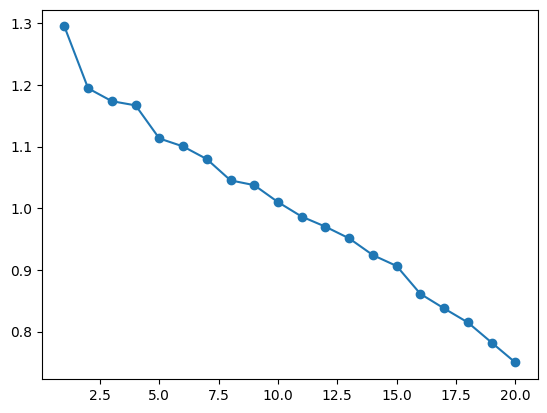

In [308]:
fa = FactorAnalyzer(n_factors= 5, rotation = None)
fa.fit(df2)

ev, v = fa.get_eigenvalues()
plt.scatter(range(1, df2.shape[1] + 1), ev)
plt.plot(range(1, df2.shape[1] + 1), ev)
print("eigen value 가 1이 되는 지점이 10개의 요인이 선택에 적합 숫자로 확인된다")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


                       0         1         2         3         4         5  \
SS Loading      1.015674  1.009818  1.005966  0.994844  0.991598  0.618637   
Proportion Var  0.050784  0.050491  0.050298  0.049742  0.049580  0.030932   
Cumulative Var  0.050784  0.101275  0.151573  0.201315  0.250895  0.281827   

                       6         7         8         9  
SS Loading      0.343211  0.226891  0.208114  0.166367  
Proportion Var  0.017161  0.011345  0.010406  0.008318  
Cumulative Var  0.298987  0.310332  0.320738  0.329056  

SS Loading (고유값, Eigen Value) : 각 요인의 고유값을 의미하며, 각 요인이 설명하는 데이터의 중요도를 나타낸다. 
일반적으로 고유값이 1.0이상이면 유의미한 요인으로 간주한다. 
1.0 이상인 요인1,2,3이 주요 요인으로 볼 수 있다. 

2. Proportion Varance: 각 요인이 데이터를 설명하는 비율을 말하며, 전체 데이터에서 60~70%을 설명하면 좋은 모델로 판단한다. 
각 요인 10개를 합쳐도 32%밖에 설명하지 못하기 때문에, 데이터가 여러개의 작은 요인으로 나눠져 있어, 주요 요인만 선택하는 것이 어려울 수있다. 

3. Culmulative Variance 
요인 9개까지 포함해도 32.9%밖에 설명하지 못함 → 데이터의 분산이 여러 요인에 걸쳐 분포



<Axes: >

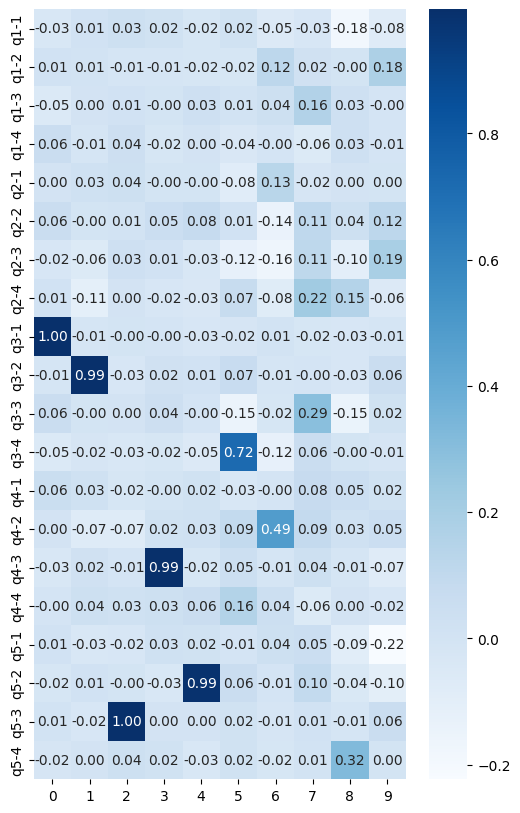

In [312]:
fa = FactorAnalyzer(n_factors = 10, rotation = 'varimax') # 최대 우도 방법
fa.fit(df2)

fa_df = pd.DataFrame(fa.get_factor_variance())
fa_df.index =['SS Loading','Proportion Var','Cumulative Var']
print(fa_df)
print("""
SS Loading (고유값, Eigen Value) : 각 요인의 고유값을 의미하며, 각 요인이 설명하는 데이터의 중요도를 나타낸다.
일반적으로 고유값이 1.0이상이면 유의미한 요인으로 간주한다.
1.0 이상인 요인1,2,3이 주요 요인으로 볼 수 있다.

2. Proportion Varance: 각 요인이 데이터를 설명하는 비율을 말하며, 전체 데이터에서 60~70%을 설명하면 좋은 모델로 판단한다.
각 요인 10개를 합쳐도 32%밖에 설명하지 못하기 때문에, 데이터가 여러개의 작은 요인으로 나눠져 있어, 주요 요인만 선택하는 것이 어려울 수있다.

3. Culmulative Variance
요인 9개까지 포함해도 32.9%밖에 설명하지 못함 → 데이터의 분산이 여러 요인에 걸쳐 분포
""")

result = pd.DataFrame(fa.loadings_,index = df2.columns)
plt.figure(figsize = (6, 10))
sns.heatmap(result, cmap = 'Blues', annot = True , fmt ='.2f')